In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

In [3]:
EN_x = pd.read_csv('EN_exog_new.csv')

In [4]:
EN_x.head()

,Unnamed: 0,0
0,0,16.730904
1,1,10.894386
2,2,19.499658
3,3,15.090033
4,4,10.817456


In [5]:
dates['Date'] = pd.to_datetime(dates[0])
y.set_index(dates['Date'],inplace=True)
X.set_index(dates['Date'],inplace=True)

In [6]:
EN_x.shape

(2923, 2)

In [7]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries, ARIAMA only consider y, setting X has no effect
X = X.iloc[:, 0: 500]

# first with the last year as test
# use the last 365 of training set as validation set
test_size =365
val_size=365
length = X.shape[0]
train1_X = X[0:length-test_size*2]
val1_X = X[length-test_size*2:length-test_size]
train1_y = y[0:length-test_size*2]
val1_y = y[length-test_size*2:length-test_size]
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

#without validation set
train1_X2 = X[0:length-test_size]
train1_y2 = y[0:length-test_size]

# second with the last 2 year as test
test_size2 =365*2
train2_X = X[0:length-test_size2-val_size]
val2_X = X[length-test_size2-val_size:length-test_size2]
train2_y = y[0:length-test_size2-val_size]
val2_y = y[length-test_size2-val_size:length-test_size2]
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

#without validation set
train2_X2 = X[0:length-test_size2]
train2_y2 = y[0:length-test_size2]


print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3653, 500)  train1 y: (3653, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
train2 X: (3288, 500)  train2 y: (3288, 1)  Test2 X: (365, 500)  Test2 y: (365, 1)


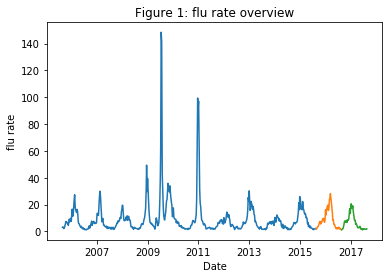

In [8]:
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = train1_y.copy()
df['y'] = train1_y.values

fig, ax = plt.subplots()
ax.plot(date[:3653],df.y,date[3653:4018],y.values[3653:4018],date[4018:],y.values[4018:])
plt.title("Figure 1: flu rate overview")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [9]:
df1 = EN_x.copy()
#df1['rate'] = train1_y2
df1.head()

,Unnamed: 0,0
0,0,16.730904
1,1,10.894386
2,2,19.499658
3,3,15.090033
4,4,10.817456


In [10]:
df=df1.iloc[:,1:2].copy()

In [11]:
df.head()

,0
0,16.730904
1,10.894386
2,19.499658
3,15.090033
4,10.817456


In [12]:
df3 = df[:2558-365].copy()
df4 = df[2558-365:].copy()

In [14]:
# the above plot shows the possible significant AR term may be 5
# anyway, just tune the possible choices
from statsmodels.tsa.arima_model import ARIMA
# fit model
model=ARIMA(endog=train2_y2[4*365:].values,exog=df3,order=[2,1,14])
model_fit = model.fit(disp=0)
print(model_fit.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2192
Model:                ARIMA(2, 1, 14)   Log Likelihood                  94.251
Method:                       css-mle   S.D. of innovations              0.230
Date:                Wed, 05 Sep 2018   AIC                           -150.503
Time:                        22:23:59   BIC                            -42.344
Sample:                             1   HQIC                          -110.973
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0065      0.005     -1.402      0.161      -0.016       0.003
0              0.0003      0.000      1.383      0.167      -0.000       0.001
ar.L1.D.y      1.0058      0.064     15.644      0.0

In [15]:
model=ARIMA(endog=train2_y2[4*365:].values,
            exog=df3,
            order=[1,2,15])
model_fit = model.fit(disp=0)
print(model_fit.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 2191
Model:                ARIMA(1, 2, 15)   Log Likelihood                  86.810
Method:                       css-mle   S.D. of innovations              0.231
Date:                Wed, 05 Sep 2018   AIC                           -135.620
Time:                        22:30:29   BIC                            -27.469
Sample:                             2   HQIC                           -96.092
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0021      0.001      2.788      0.005       0.001       0.004
0              -0.0002   8.39e-05     -2.802      0.005      -0.000   -7.06e-05
ar.L1.D2.y     -0.3283        nan        nan    

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [16]:
model=ARIMA(endog=train2_y2[4*365:].values,
            exog=df3,
            order=[1,2,14])
model_fit = model.fit(disp=0)
print(model_fit.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 2191
Model:                ARIMA(1, 2, 14)   Log Likelihood                  86.537
Method:                       css-mle   S.D. of innovations              0.231
Date:                Wed, 05 Sep 2018   AIC                           -137.074
Time:                        22:35:33   BIC                            -34.616
Sample:                             2   HQIC                           -99.627
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0021      0.001      2.874      0.004       0.001       0.003
0              -0.0002    7.9e-05     -2.892      0.004      -0.000   -7.36e-05
ar.L1.D2.y     -0.0608      0.063     -0.960    

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(endog=train2_y2[4*365:].values,
            exog=df3,
            order=[2,1,15])
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [15]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)

train1 = train2_y2[4*365:].values
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:2558-365].copy()
df4 = df[2558-365:].copy()

history = [x for x in train1]
predict = list()
training_mod = sm.tsa.statespace.SARIMAX(endog =train1,
                                  exog=df3,
                                  trend='n', order=(2,1,15),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
training_res = training_mod.fit()
training_mod.fit(disp=0)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [14]:
train1 = train2_y2[4*365:].values
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:2558-365].copy()
df4 = df[2558-365:].copy()

history = [x for x in train1]
predict = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:2558-365+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4.iloc[[t]]
    output = model_fit.forecast(steps=1,exog=exog_test)
    yhat = output.values[0]
    print(yhat)
    predict.append(yhat)
    obs = test1[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict)
rmse1 = sqrt(mean_squared_error(test1, predict))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

1.859867145594446
1
1.756471002212132
2
1.680594410095802
3
1.6215244383588068
4
1.8861906947901703
5
1.9640299403852572
6
2.068775902527785
7
2.1488493199929732
8
2.22944021083104
9
2.34013705607312
10
2.374853576509758
11
2.4112446107710754
12
2.4277422505316
13
2.462594042546047
14
2.4741036108834953
15
2.490346651908301
16
2.5317107506886822
17
2.50491831326549
18
2.8587852022228484
19
2.9998230119510794
20
3.1627884528905836
21
3.3091916464466973
22
3.45053101103658
23
3.6200619441971753
24
3.6681072516135544
25
3.6711226501588583
26
3.677447781691245
27
3.700946545787884
28
3.7086695345860465
29
3.710130218569696
30
3.741603488283557
31
3.708886677323644
32
3.992825653489479
33
4.093049763356303
34
4.218172918572045
35
4.327583080350489
36
4.427965043618341
37
4.559582729954396
38
4.598342858818514
39
4.995250635996935
40
5.194327911341221
41
5.4098118863841735
42
5.61649774334236
43
5.805992499057841
44
6.0325519397664085
45
6.077962532512227
46
6.399834966241252
47
6.5598307186

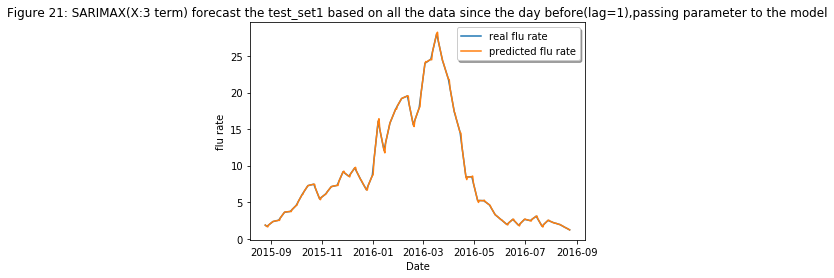

In [16]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:],predict,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 21: SARIMAX(X:3 term) forecast the test_set1 based on all the data since the day before(lag=1),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [21]:
## lag=5
train1 = train2_y2[4*365:3653-4].values
test = y.values[3653-4:]
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:2558-365].copy()
df4 = df[2558-365-4:].copy()

history = [x for x in train1]
predict2 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:2558-365-4+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+5]
    output = model_fit.forecast(steps=5,exog=exog_test)
    yhat = output.values[4]
    print(yhat)
    predict2.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict2)
rmse1 = sqrt(mean_squared_error(test1, predict2))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict2
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

2.4397528576489873
1
1.9089422992190044
2
1.7228141018704972
3
1.6310456117582808
4
1.5104125041812269
5
1.4727669025704175
6
1.5200548976177743
7
1.488554323870083
8
2.348753368276364
9
2.3498094175515707
10
2.371959211317124
11
2.348658437433577
12
2.4032085101639336
13
2.5547433802458626
14
2.624095021797315
15
2.6351180569641772
16
2.585884316870523
17
2.5319602490898645
18
2.448608327458679
19
2.4417816704290813
20
2.5102742322741447
21
2.5113264708638403
22
3.575094961994427
23
3.6448568268154418
24
3.677440921790718
25
3.685284527790469
26
3.737469150461534
27
3.8847895951112252
28
3.9735679361892355
29
3.8581517580361133
30
3.802317423408093
31
3.7454827644053177
32
3.664876812667333
33
3.630325156208635
34
3.695613454737243
35
3.6886285413410436
36
4.556073639588809
37
4.578969947312735
38
4.606047390878823
39
4.602895850944546
40
4.63804775674835
41
4.77997092053543
42
4.8589885630783485
43
5.938358273487944
44
6.082225657735365
45
6.115370845800461
46
6.138246199477321
47
6.

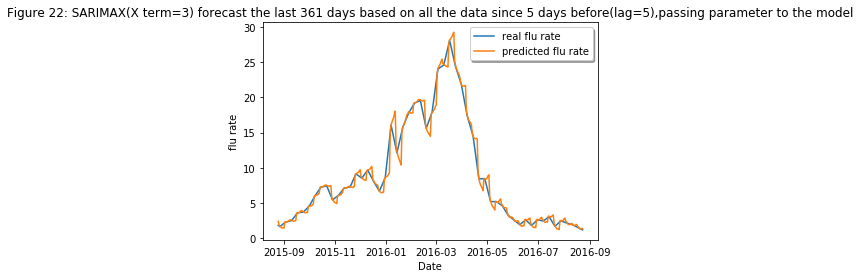

In [22]:
## lag=5
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:],predict2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 22: SARIMAX(X term=3) forecast the last 361 days based on all the data since 5 days before(lag=5),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [23]:
## lag=10
train1 = train2_y2[4*365:3653-9].values
test = y.values[3653-9:]
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:2558-365].copy()
df4 = df[2558-365-9:].copy()

history = [x for x in train1]
predict3 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:2558-365-9+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+10]
    output = model_fit.forecast(steps=10,exog=exog_test)
    yhat = output.values[9]
    print(yhat)
    predict3.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict3)
rmse1 = sqrt(mean_squared_error(test1, predict3))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict3
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

2.4442063281420943
1
2.4434245155025054
2
2.348189406534931
3
2.3579059836924303
4
2.4938266471821113
5
2.4933944787466467
6
1.708885150421909
7
1.515354017759757
8
1.4238330438064666
9
1.2622894249915477
10
1.2666554282435327
11
1.3776896151857336
12
1.3709718872138705
13
2.674358108943903
14
2.5898768551474527
15
2.637112801816901
16
2.5951776159941358
17
2.610577919004312
18
2.749254401541952
19
2.764307914469749
20
2.7060799527733286
21
2.5767332922651724
22
2.5282994738890037
23
2.4018105472146742
24
2.4023617667443244
25
2.4965368326944417
26
2.4932706896958705
27
4.033139072773179
28
3.9761030742056453
29
4.035555273045128
30
4.024873407112156
31
4.019191764621998
32
4.142308286373182
33
4.163552617299483
34
3.9119289682106255
35
3.7743321155701235
36
3.7149576214817044
37
3.5967139943180673
38
3.5650151821085942
39
3.6683237546334504
40
3.660965133042374
41
4.93218861406714
42
4.849458812804154
43
4.901178699236702
44
4.880694012665417
45
4.86279384260887
46
4.989925012830472
4

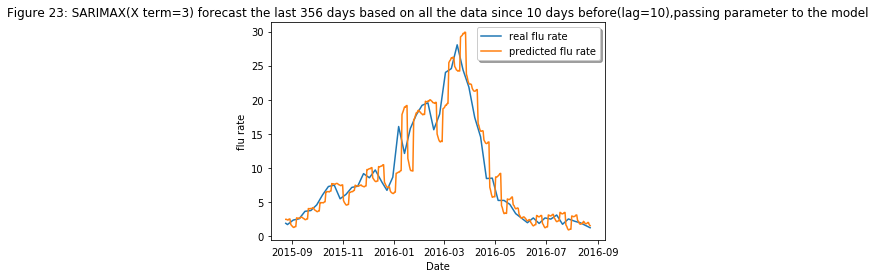

In [24]:
# visualize lag=10
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:],predict3,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 23: SARIMAX(X term=3) forecast the last 356 days based on all the data since 10 days before(lag=10),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [16]:
## lag=14
train1 = train2_y2[4*365:3653-13].values
test = y.values[3653-13:]
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:2558-365].copy()
df4 = df[2558-365-13:].copy()

history = [x for x in train1]
predict4 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:2558-365-13+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+14]
    output = model_fit.forecast(steps=14,exog=exog_test)
    yhat = output.values[13]
    print(yhat)
    predict4.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict4)
rmse1 = sqrt(mean_squared_error(test1, predict4))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict4
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

1.9000651092777905
1
2.0567932470022283
2
2.042030882959015
3
2.6721405045419533
4
2.4877689365531546
5
2.4724336737233057
6
2.3423965081426785
7
2.365427890135074
8
2.5252790734829373
9
2.521211957786281
10
1.5989467804094817
11
1.4034628333775858
12
1.3454494610998025
13
1.208041078986566
14
1.227512528413286
15
1.3647082509395496
16
1.357677088884961
17
2.8683621240048653
18
2.703016405834186
19
2.713158107466245
20
2.6045727893109185
21
2.631862874625985
22
2.791146615114942
23
2.801643247352524
24
2.7236977145193473
25
2.5653032039124612
26
2.527529124455111
27
2.3895616881692874
28
2.4003605920525617
29
2.5112609557501813
30
2.5070701747770907
31
4.292034074602579
32
4.1456620030336016
33
4.146215977754753
34
4.062647351903984
35
4.065699869685037
36
4.205839444963305
37
4.221351516485696
38
3.9165585091930226
39
3.7572131655069017
40
3.710764152370961
41
3.592662525440801
42
3.5649258417369962
43
3.6883547794702842
44
3.678279250841485
45
5.150498768429684
46
4.983451518739375
4

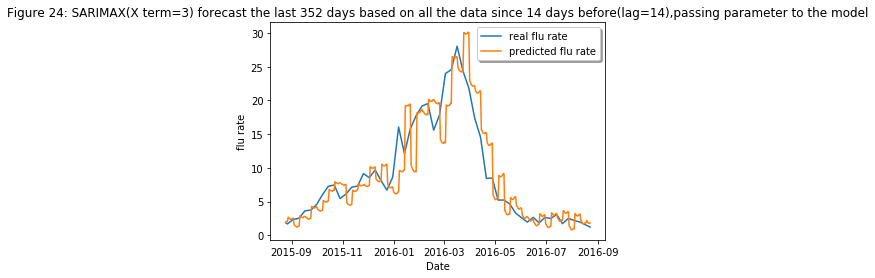

In [17]:
# visualize lag=14
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:],predict4,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 24: SARIMAX(X term=3) forecast the last 352 days based on all the data since 14 days before(lag=14),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [18]:
## lag=28
train1 = train2_y2[4*365:3653-27].values
test = y.values[3653-27:]
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:2558-365].copy()
df4 = df[2558-365-27:].copy()

history = [x for x in train1]
predict5 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:2558-365-27+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,15),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+28]
    output = model_fit.forecast(steps=28,exog=exog_test)
    yhat = output.values[27]
    print(yhat)
    predict5.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict5)
rmse1 = sqrt(mean_squared_error(test1, predict5))

corr_y = test1_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict5
corr1 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr1)

1.421110197566989
1
1.5732138693361426
2
1.5708046993517077
3
2.152684145783264
4
1.9386503168458302
5
1.924722968752079
6
1.778172035838628
7
1.8189417675120916
8
1.990639460235145
9
1.9931096131263328
10
2.252032888737306
11
2.064355196931545
12
2.0261337337957976
13
1.8813109777914208
14
1.9090638885205253
15
2.0709128698016555
16
2.0563533472705284
17
2.7323657599937103
18
2.531237966724736
19
2.524795553795614
20
2.379404350839716
21
2.3959162294341234
22
2.5565864618858174
23
2.553679433735904
24
1.5432756326885941
25
1.3413105644481966
26
1.3052962754621196
27
1.1584938401940874
28
1.1766447211424214
29
1.312155223825612
30
1.3182579661288247
31
2.941317687766019
32
2.771077508639874
33
2.7862334699498095
34
2.6643829070624188
35
2.684543713062722
36
2.8426407701592824
37
2.8537770588661857
38
2.7568849652441076
39
2.5896226025789684
40
2.553451148073058
41
2.4027968991011437
42
2.410437534446078
43
2.5240056619470312
44
2.520378440374458
45
4.446693186265586
46
4.27625078133393

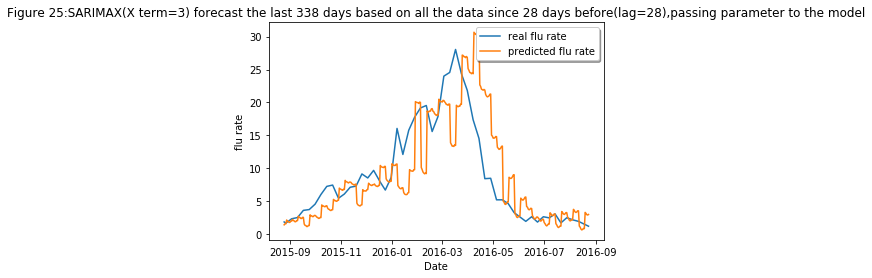

In [19]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],predict5,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 25:SARIMAX(X term=3) forecast the last 338 days based on all the data since 28 days before(lag=28),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

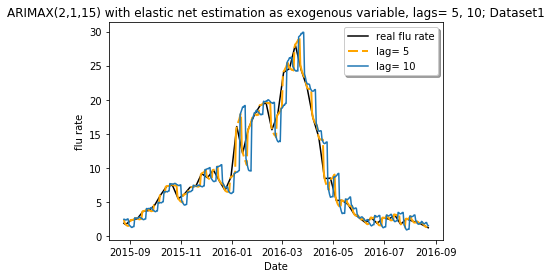

In [26]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:],df.y[3653:4018],label='real flu rate', color='black')
ax.plot(date[3653:],predict2,dashes=[5,2,20,2], linewidth=2,color='orange',label='lag= 5')
ax.plot(date[3653:],predict3,label='lag= 10')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("ARIMAX(2,1,15) with elastic net estimation as exogenous variable, lags= 5, 10; Dataset1")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("arimax_en_510_test1.pdf", bbox_inches='tight')

plt.show()

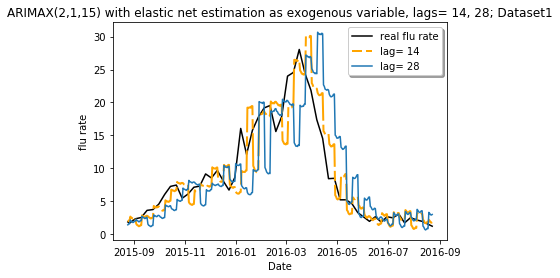

In [25]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:],df.y[3653:4018],label='real flu rate', color='black')
ax.plot(date[3653:],predict4,dashes=[5,2,20,2], linewidth=2,color='orange',label='lag= 14')
ax.plot(date[3653:],predict5,label='lag= 28')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("ARIMAX(2,1,15) with elastic net estimation as exogenous variable, lags= 14, 28; Dataset1")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("arimax_en_1428_test1.pdf", bbox_inches='tight')

plt.show()

In [16]:
corr_y['y_pred'].to_csv('ARIMAX_EN_t1.csv',header=False)